# London Labyrinth CNN Classifyer

 Importing necessary modules

In [25]:
import torch
import random
import warnings
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from random import randint
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Import the Original Dataset

The images are stored in the Git `Original Images` folder with the following structure:

 `Original Images`/
  - 1 - `Chesham`/
    - CheshamCloseup.jpg
    - CheshamSurrounding.jpg
  - 2 - `Chalford & Latimer`/
    - ChalfordCloseup.jpg
    - ChalfordSurrounding.jpg \

 etc.


In [5]:
#!git clone https://github.com/Sim589/Labyrinths
data_dir = '/content/Labyrinths/python_ml/Original Images'
original_dataset = datasets.ImageFolder(root=data_dir, transform=None)

In [40]:
class AugmentDataset(Dataset):
    def __init__(self, original_dataset, n_augmentations=1):
        self.original_dataset = original_dataset
        self.n_augmentations = n_augmentations
        self.augmentation_transforms = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((200, 200)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(30),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.GaussianBlur(kernel_size=3),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.original_dataset) * self.n_augmentations

    def __getitem__(self, idx):
        original_idx = idx // self.n_augmentations
        image, label = self.original_dataset[original_idx]
        augmented_image = self.augmentation_transforms(image)
        return augmented_image, label

def plot_dataset(data_loader, class_names):
    def imshow(img, ax):
        img = img * 0.5 + 0.5  # Undo normalization
        np_img = img.numpy()
        np_img = np.transpose(np_img, (1, 2, 0))
        ax.imshow(np_img.squeeze(), cmap="gray")
        ax.axis('off')

    # Extract images and labels from the data loader
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Calculate the number of rows and columns for subplots
    n_plot = 5
    num_cols = 5  # Limit columns to 5 to avoid the error
    num_rows = ceil(n_plot / num_cols)

    # Visualize sample images for each station class
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 9))  # Adjusted subplots
    fig.suptitle("Sample Augmented Images for Each Station", fontsize=16)

    for i, (station, ax) in enumerate(zip(class_names[:n_plot], axes.flat)):
        # Select the images belonging to the current station category
        station_images = images[labels == i][:2]
        ax.set_title(station, fontsize=12)

        # Plot each image within the station_images subset on the current subplot
        for row in range(len(station_images)):
            imshow(station_images[row], ax)  # Plot on the current subplot

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Create augmented datasets for training and testing
# n_augmentations is the number of images that will be generated from any 1 original photo
n_augmentations = 15
augmented_training_dataset = AugmentDataset(original_dataset, n_augmentations)
augmented_test_dataset = AugmentDataset(original_dataset, n_augmentations)

# Create DataLoaders for both training and testing datasets
train_loader = DataLoader(augmented_training_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(augmented_test_dataset, batch_size=32, shuffle=False)
class_names = original_dataset.classes

In [54]:
#plot_dataset(train_loader, class_names)

In [106]:
class CNN(nn.Module):
    def __init__(self, num_classes, input_size=200, device='cpu', learning_rate=0.001):
        #We love stealing from the inbuilt pytorch nn.Module
        super(CNN, self).__init__()
        self.device = device
        self.epoch = 0
        self.loss_history = []

        # Define convolutional and pooling layers
        # This is probably overkill size, and I will cut this down gradually
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Move layers to the specified device (probably GPU)
        self.conv1.to(device)
        self.conv2.to(device)
        self.conv3.to(device)
        self.pool.to(device)

        # Calculate flattened size after convolution and pooling layers
        example_input = torch.randn(1, 1, input_size, input_size, device=self.device)
        example_output = self.pool(self.conv3(self.pool(self.conv2(self.pool(self.conv1(example_input))))))
        self.flattened_size = example_output.numel()

        # Define fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 256).to(device)
        self.fc2 = nn.Linear(256, num_classes).to(device)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)              #Flatten the photo like a pancake
        x = F.relu(self.fc1(x))                #All my homies love relu
        x = self.fc2(x)
        return x

    def train_model(self, train_loader, criterion, num_epochs=10):
        self.train()  # Set the model to training mode
        for epoch in range(self.epoch, self.epoch + num_epochs):  # Continue training from the last epoch
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()             # Zero the gradients
                outputs = self(images)            # Forward pass
                loss = criterion(outputs, labels) # Calculate loss
                loss.backward()                   # Backward pass
                self.optimizer.step()                  # Update weights

                running_loss += loss.item()

            avg_loss = running_loss / len(train_loader)
            self.loss_history.append(avg_loss)  # Store the average loss for this epoch

            print(f"Epoch {epoch+1}/{self.epoch + num_epochs}, Loss: {avg_loss:.4f}")

        self.epoch += num_epochs  # Update the current epoch after training

    def evaluate_model(self, test_loader, verbose = True):
        self.eval()  # Set the model to evaluation mode to not mess with gradients
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)  # Ensure labels are on the same device as the model
                outputs = self(images)
                _, predicted = torch.max(outputs, 1)

                # Append predictions and labels directly on the GPU and only move to CPU after processing
                all_labels.append(labels)
                all_preds.append(predicted)

        # After the loop, move everything to CPU and convert to NumPy arrays for analysis
        all_labels = torch.cat(all_labels).cpu().numpy()
        all_preds = torch.cat(all_preds).cpu().numpy()

        if verbose:
            accuracy = np.mean(all_labels == all_preds)
            print("Accuracy is", accuracy)

        return np.array(all_labels), np.array(all_preds)

    def plot_confusion_matrix(self, true_labels, predicted_labels, class_names):
        cm = confusion_matrix(true_labels, predicted_labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.xticks(rotation=90)
        plt.show()

    def save_model(self, path):
        """Save model parameters, optimizer state, epoch, and training loss history to a specified path."""
        state = {
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': self.epoch,
            'loss_history': self.loss_history,
        }

        torch.save(state, path)
        print(f"Model, optimizer states, epoch, and loss history saved to {path}")


    def load_model(self, path):
        """Load model parameters, optimizer state, epoch, and training loss history from a specified path."""
        checkpoint = torch.load(path, map_location=self.device)
        self.load_state_dict(checkpoint['model_state_dict'])
        self.epoch = checkpoint['epoch']  # Load the epoch
        self.loss_history = checkpoint['loss_history']  # Load the loss history

        print(f"Model loaded from {path}")

        if 'optimizer_state_dict' in checkpoint:
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print("Optimizer state loaded")

        print(f"Resuming from epoch {self.epoch}")

In [107]:
warnings.filterwarnings("ignore", category=FutureWarning)
num_classes = len(class_names)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  #Would recommend switching runtime on google colab to GPU
model3 = CNN(num_classes, device=device)
criterion = nn.CrossEntropyLoss()

model3.train_model(train_loader, criterion, num_epochs=2)
#model3.save_model('/content/Labyrinths/python_ml/cnn_model.pth')
#true_labels, predicted_labels = model2.evaluate_model(test_loader)

Epoch 1/2, Loss: 4.8783
Epoch 2/2, Loss: 3.3599


In [109]:
model3.train_model(train_loader, criterion, num_epochs=2)

Epoch 5/6, Loss: 0.6281
Epoch 6/6, Loss: 0.4071


In [81]:
#!ssh-keygen -t rsa -b 4096 -C "wasimahmed0606@gmail.com" -f /root/.ssh/id_rsa -N ""
#!cat /root/.ssh/id_rsa.pub
#!mkdir -p /root/.ssh
#!echo -e "Host github.com\n\tStrictHostKeyChecking no\n" >> /root/.ssh/config
#!chmod 700 /root/.ssh
#!chmod 600 /root/.ssh/id_rsa
#!ssh -T git@github.com


Hi Sim589! You've successfully authenticated, but GitHub does not provide shell access.


In [87]:
%cd /content/Labyrinths

# Stage, commit, and push the model file to GitHub
!git config --global user.email "wasimahmed0606@gmail.com"
!git config --global user.name "Wasim Ahmed"
!git checkout ml-testing
!git add python_ml/cnn_model.pth
!git commit -m "Add saved model file cnn_model.pth"
!git remote -v
!git remote set-url origin git@github.com:Sim589/Labyrinths.git
!git push --set-upstream origin ml-testing


/content/Labyrinths
Already on 'ml-testing'
On branch ml-testing
nothing to commit, working tree clean
origin	git@github.com:username/repository.git (fetch)
origin	git@github.com:username/repository.git (push)
Enumerating objects: 6, done.
Counting objects: 100% (6/6), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 71.78 MiB | 4.44 MiB/s, done.
Total 4 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
remote: warning: See https://gh.io/lfs for more information.
remote: warning: File python_ml/cnn_model.pth is 78.62 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
To github.com:Sim589/Labyrinths.git
   befbf38..c0db154  ml-testing -> ml-testing
Branch 'ml-testing' set up to track remote branch 'ml-testing' from 'ori

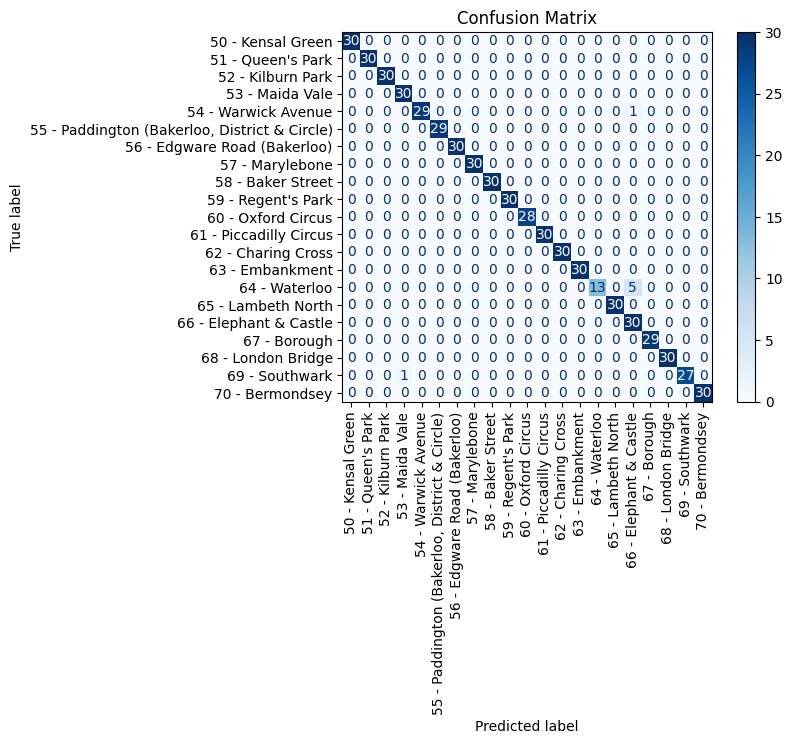

In [37]:
start_prefix = 50
end_prefix = 70

# Parse numeric prefixes from class names and get their indices within the range, sorted in ascending order
selected_indices = sorted(
    [i for i, name in enumerate(class_names) if start_prefix <= int(name.split('-')[0]) <= end_prefix],
    key=lambda x: int(class_names[x].split('-')[0])
)

# Filter true and predicted labels to include only those within the selected class range
true_labels_subset = []
predicted_labels_subset = []

for true, pred in zip(true_labels, predicted_labels):
    if true in selected_indices and pred in selected_indices:
        true_labels_subset.append(true)
        predicted_labels_subset.append(pred)

# Create a sorted subset of class names based on the selected indices
class_names_subset = [class_names[i] for i in selected_indices]

# Remap the labels to match the sorted indices for compatibility with the confusion matrix
index_mapping = {original_idx: new_idx for new_idx, original_idx in enumerate(selected_indices)}
true_labels_subset = [index_mapping[label] for label in true_labels_subset]
predicted_labels_subset = [index_mapping[label] for label in predicted_labels_subset]

# Plot the sorted, smaller confusion matrix
model.plot_confusion_matrix(true_labels_subset, predicted_labels_subset, class_names_subset)


In [100]:
!wget https://raw.githubusercontent.com/Sim589/Labyrinths/ml-testing/python_ml/cnn_model.pth -O '/content/Labyrinths/python_ml/cnn_model2.pth'
model2_loaded = CNN(num_classes, device=device)
model2_loaded.load_model('/content/Labyrinths/python_ml/cnn_model2.pth')
true_labels, predicted_labels = model2_loaded.evaluate_model(test_loader)

--2024-11-10 02:34:53--  https://raw.githubusercontent.com/Sim589/Labyrinths/ml-testing/python_ml/cnn_model.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82434452 (79M) [application/octet-stream]
Saving to: ‘/content/Labyrinths/python_ml/cnn_model2.pth’

/content/Labyrinths 100%[===================>]  78.62M   425MB/s    in 0.2s    

2024-11-10 02:34:57 (425 MB/s) - ‘/content/Labyrinths/python_ml/cnn_model2.pth’ saved [82434452/82434452]

Model loaded from /content/Labyrinths/python_ml/cnn_model2.pth
Resuming from epoch 2
0.007407407407407408


In [101]:
model2_loaded.train_model(train_loader, criterion, optimizer, num_epochs=2)

Epoch 3/4, Loss: 4.9058
Epoch 4/4, Loss: 4.9058
